Sehr geehrter Herr Haas,

anbei finden Sie erste Ergebnisse meiner Arbeit. 
Zur Analyse der Zeitreihen nutze ich hauptsächlich die Python Library Darts (publiziert 2020 von Unit8 auf [GitHub](https://unit8co.github.io/darts/README.html)). Diese bietet eine Art standardiserte Oberfläche für relevante ML Libraries wie Sklearn, PyTorch oder MLflow und basiert auf Numpy und Pandas. Die Dokumentation ist hervorragend aufgebaut. Neben Forecasting beinhaltet dies insbesondere auch Funktionen zum Hyperparameter Tuning und Backtesting.

Leider habe ich keine Rückmeldung der Autoren des zu replizierenden Papers erhalten, weshalb ich vom "Scratch" starte.

Ich habe versucht das Notebook möglichst übersichtlich aufzubauen und sauber zu kommentieren.

Grundidee nach meinem Verständnis:
- Verwendung der historischen Index-Daten für 36 Jahre zum Forecasting von zukünftigen Returns durch verschiedene Modelle (Paper konzentriert sich auf Shrinkage, Dimensionality Reduction, Nonlinear ML und Kombinationen dieser)
- basierend auf den jeweiligen Forecastings werden Portfolios mit Hilfe von Mean-Variance Methoden erstellt
- anschließend werden die Returns dieser Portfolios mit denen aus klassischen Ansätzen wie "Equal-Weighting" oder "Historical Average" verglichen

Falls Sie die Packages noch nicht installiert haben, bereite ich Ihnen die Install Statements in der nächsten Code-Zeile einfach auf. Bitte führen Sie die install-statements einzeln in Ihrem Terminal aus oder, falls Sie mit PyCharm arbeiten, nutzen Sie gerne den package installer dort.

In [3]:
# pip install statements
#pip install numpy;
#pip install pandas;
#pip install matplotlib;
#pip install sklearn;
#pip install scipy;
#pip install pystan;
#pip install lightgbm;
#pip install warnings;

# check all necessary packages to install darts!!!
#pip install darts;

In [4]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score
import sklearn


import warnings

future project; include wandb

"""
Mit "Wandb" können Benutzer ihre Maschinenlernprojekte in der Cloud verwalten und überwachen. Die Plattform bietet eine Vielzahl von Funktionen, darunter Experiment-Tracking, 
Hyperparameter-Optimierung, Modellvisualisierung, automatische Warnmeldungen bei Problemen während des Trainings und vieles mehr.
"""

In [7]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))

Ggfs. müssten Sie den Datei-Pfad zum Datenladen anpassen.

In [8]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [9]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()
#returns.head(2)

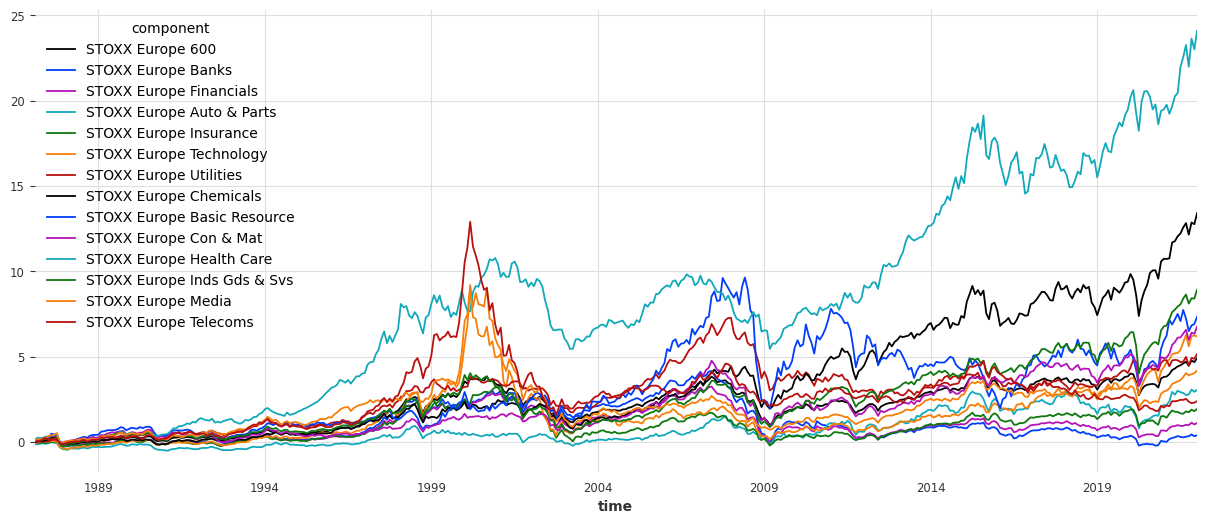

In [10]:
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

# plot the cumulative returns
cum_returns.plot(figsize=(15, 6));

In [11]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(cum_returns)

In [12]:
# show the average cumulative monthly return for all assets
average_returns = cum_returns.last_values().mean()
average_returns

6.4284077800970225

_______

Nachdem wir nun die allgemeinen Basics gelegt haben, sprich, die kumulativen returns ermittelt  und das richtige Objekt-Format (Darts TimeSeries) implementiert haben, können wir im nächsten Schritt die zu replizierenden Modelle aufbauen.

Struktur:
1. Shrinkage Methods
2. Dimensionality reduction methods
3. Nonlinear ML methods
4. Combination ML models

Shrinkage methods:
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elastic Net
- Bridge Regression

Darts bietet wie erwähnt standardisierte Modelle an, in denen dann wie von mir verwendet, Sklearn-Methoden als Parameter eingebaut werden können.

Um die Modelle generell im ersten Schritt zu bauen, wurde kein tieferer Sinn bei den Parametern gedacht. Dies sollte im Hyperparamter Tuning für diese Daten erfolgen (dazu später mehr).

In [13]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

In [14]:
# linear regression model
linear_regression = LinearRegressionModel(lags=1) # output chunks standard is 1
linear_regression.fit(train)
linear_forecast = linear_regression.predict(len(test))

In [55]:
mean_return_lm = linear_forecast.last_values().mean()
mean_return_lm

6.552746050557699

In [15]:
# ridge regression model
ridge_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Ridge(alpha=1))
ridge_regression.fit(train)
ridge_forecast = ridge_regression.predict(len(test))

In [16]:
mean_return_rr = ridge_forecast.last_values().mean()
mean_return_rr

8.43829163754281

In [17]:
# lasso regression model
lasso_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Lasso(alpha=1))
lasso_regression.fit(train)
lasso_forecast = lasso_regression.predict(len(test))

In [59]:
mean_return_lr = lasso_forecast.last_values().mean()
mean_return_lr

2.082050266832744

In [18]:
# elastic net regression model
elastic_net_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.ElasticNet(alpha=1))
elastic_net_regression.fit(train)
elastic_net_forecast = elastic_net_regression.predict(len(test))

In [61]:
mean_return_el = elastic_net_forecast.last_values().mean()
mean_return_el

2.1234070573787713

In [19]:
# bridge regression model
bridge_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.LassoLarsCV(cv=3))
bridge_regression.fit(train)
bridge_forecast = bridge_regression.predict(len(test))

In [63]:
mean_return_br = bridge_forecast.last_values().mean()
mean_return_br

5.117185043891381

Die Plots sind natürlich extrem unübersichtlich, da ich bisher alle gemessenen und vorhergesagten Werte für 14 Variablen plotte. Dies würde ich zu einem späteren Zeitpunkt übersichtlicher gestalten. (Mal abgesehen davon, dass Python mir hier nur 10 von 14 Variablen in die Plots einbezieht). Die Trends sind dennoch deutlich zu erkennen.

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

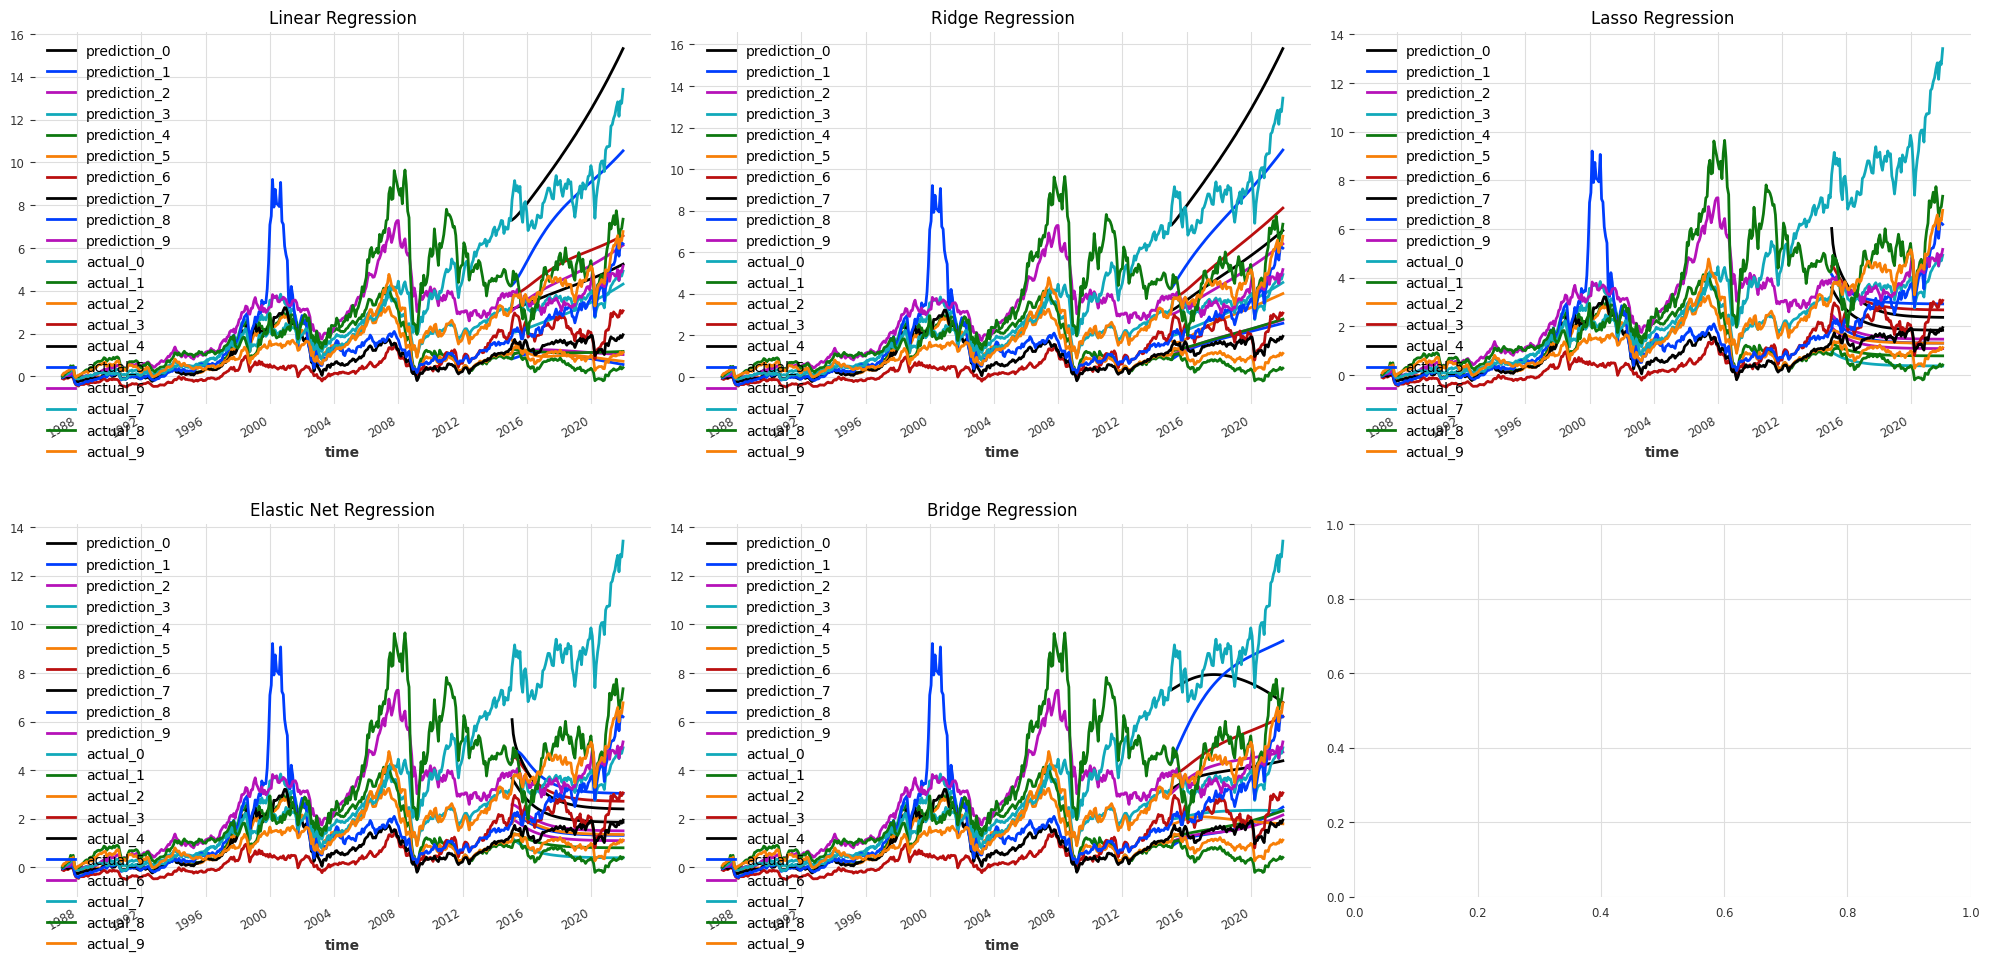

In [20]:
# Plot the predictions
shrinkage_forecasts = {'Linear Regression': linear_forecast,
                       'Ridge Regression': ridge_forecast,
                       'Lasso Regression': lasso_forecast,
                       'Elastic Net Regression': elastic_net_forecast,
                       'Bridge Regression': bridge_forecast}

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()

for i, (name, forecast) in enumerate(shrinkage_forecasts.items()):
    forecast.plot(label='prediction', ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)

plt.tight_layout();

Dimensionality reduction methods:
- PLS Regression
- PLS Canonical
- CCA

In [21]:
# pls regression model
pls_regression = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.PLSRegression(n_components=1))
pls_regression.fit(train)
pls_forecast = pls_regression.predict(len(test))

In [66]:
mean_return_pls = pls_forecast.last_values().mean()
mean_return_pls

3.49219137912649

In [22]:
# pls canonical regression model
pls_canonical = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.PLSCanonical(n_components=1))
pls_canonical.fit(train)
pls_canonical_forecast = pls_canonical.predict(len(test))

In [68]:
mean_return_can = pls_canonical_forecast.last_values().mean()
mean_return_can

4.871637099803123

In [23]:
# cca regression model
cca = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.CCA(n_components=1))
cca.fit(train)
cca_forecast = cca.predict(len(test))

In [70]:
mean_return_cca = cca_forecast.last_values().mean()
mean_return_cca

4.541832920110343

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

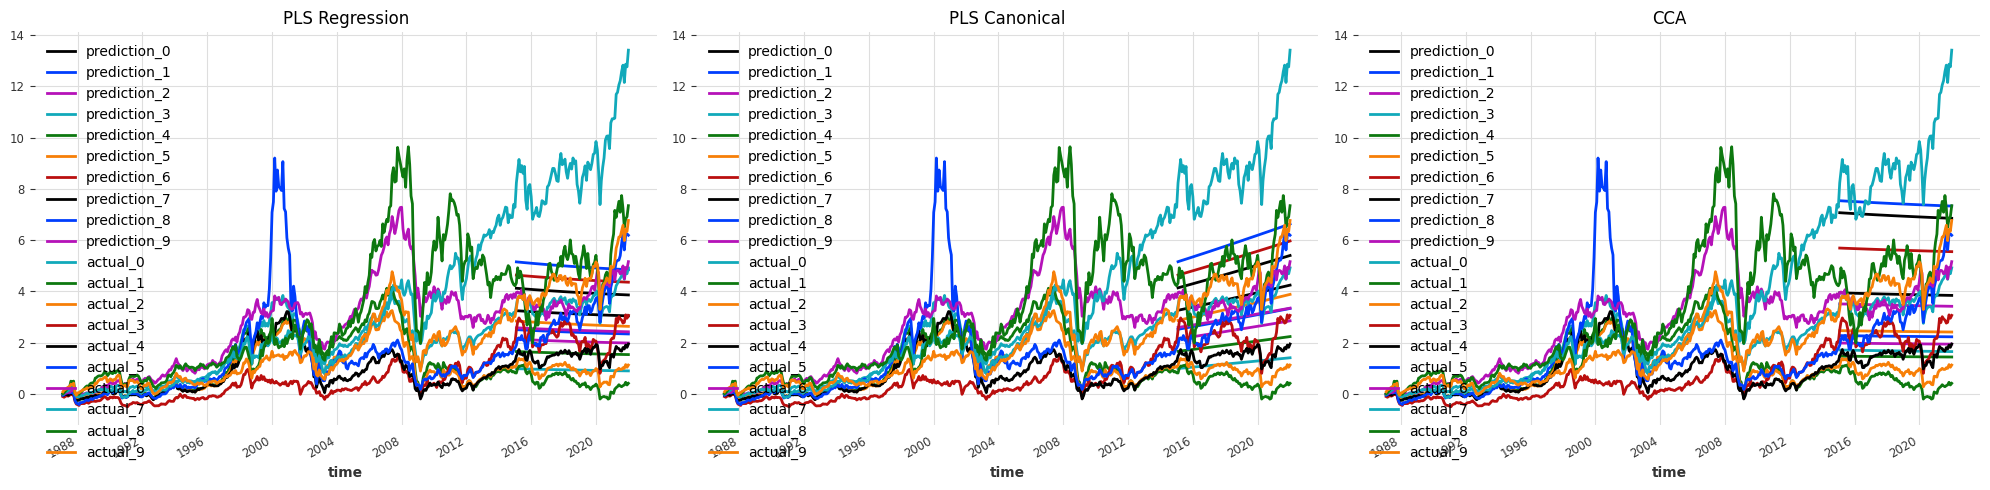

In [24]:
# Plot the predictions
dimensionality_forecasts = {'PLS Regression': pls_forecast,
                            'PLS Canonical': pls_canonical_forecast,
                            'CCA': cca_forecast}

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()

for i, (name, forecast) in enumerate(dimensionality_forecasts.items()):
    forecast.plot(label='prediction', ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)

plt.tight_layout();

Nonlinear ML methods
- Random Forest Regressor
- Gradient Boosting Regressor
- Ada Boost Regressor 
- ExtraTreesRegressor
- Support Vector Machine Regressor

In [38]:
# random forest model
random_forest = RandomForest(lags=3, output_chunk_length=1, n_estimators=100)
random_forest.fit(train)
random_forest_forecast = random_forest.predict(len(test))

In [73]:
mean_return_rf = random_forest_forecast.last_values().mean()
mean_return_rf

3.241469837703614

In [29]:
# gradient boosting model
gb_boosting = RegressionModel(lags=1, output_chunk_length=1, 
                              model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0))
gb_boosting.fit(train)
gb_boosting_forecast = gb_boosting.predict(len(test))

In [75]:
mean_return_gb = gb_boosting_forecast.last_values().mean()
mean_return_gb

3.8297386225345957

In [30]:
# ada boosting model
ada_boosting = RegressionModel(lags=1, output_chunk_length=1,
                                 model=sklearn.ensemble.AdaBoostRegressor(n_estimators=100, random_state=0))
ada_boosting.fit(train)
ada_boosting_forecast = ada_boosting.predict(len(test))

In [77]:
mean_return_adab = ada_boosting_forecast.last_values().mean()
mean_return_adab

3.833027075881031

In [31]:
# extra tree regression model
extra_tree = RegressionModel(lags=1, output_chunk_length=1,
                                    model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0))
extra_tree.fit(train)
extra_tree_forecast = extra_tree.predict(len(test))

In [79]:
mean_return_et = extra_tree_forecast.last_values().mean()
mean_return_et

3.855870430456567

In [32]:
# support vector regression model
svr = RegressionModel(lags=1, output_chunk_length=1,
                                model=sklearn.svm.SVR(kernel='rbf', C=1e3, gamma=0.1))
svr.fit(train)
svr_forecast = svr.predict(len(test))

In [81]:
mean_return_sv = svr_forecast.last_values().mean()
mean_return_sv

3.4855685767469686

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

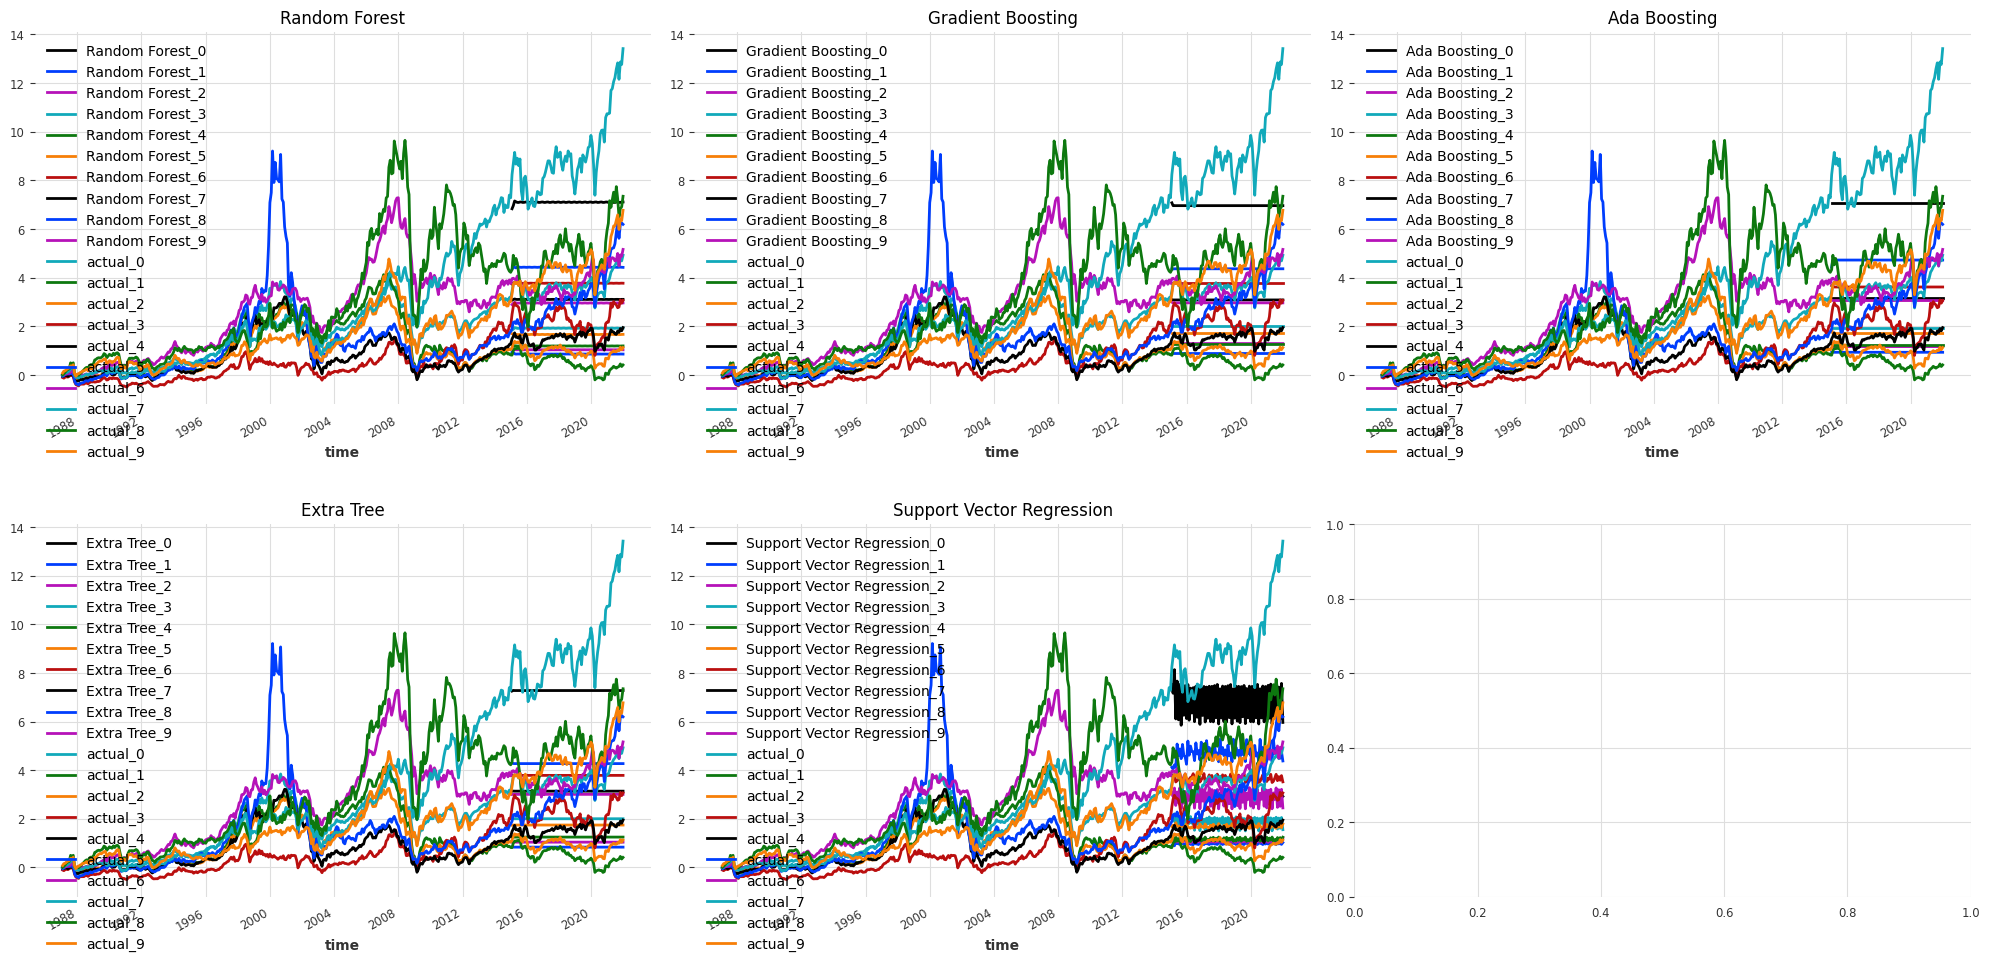

In [39]:
nonlinear_ML_forecasts = {'Random Forest': random_forest_forecast,
                          'Gradient Boosting': gb_boosting_forecast,
                          'Ada Boosting': ada_boosting_forecast,
                          'Extra Tree': extra_tree_forecast,
                          'Support Vector Regression': svr_forecast}

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()

for i, (name, forecast) in enumerate(nonlinear_ML_forecasts.items()):
    forecast.plot(label=name, ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)
    
plt.tight_layout();

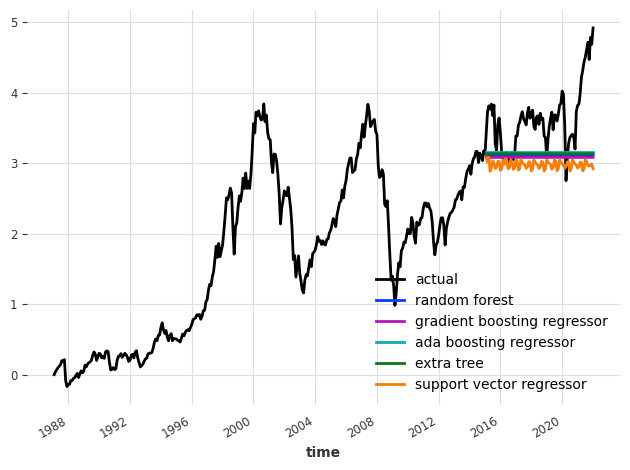

In [40]:
# plot only the outcome of the benchmark
cum_returns["STOXX Europe 600"].plot(label='actual')
random_forest_forecast["STOXX Europe 600"].plot(label="random forest")
gb_boosting_forecast["STOXX Europe 600"].plot(label="gradient boosting regressor")
ada_boosting_forecast["STOXX Europe 600"].plot(label="ada boosting regressor")
extra_tree_forecast["STOXX Europe 600"].plot(label="extra tree")
svr_forecast["STOXX Europe 600"].plot(label="support vector regressor")
    
plt.tight_layout();

Combination ML methods
- combination shrinkage
- combination dimensionality reduction
- combination nonlinear ML

In [41]:
# ensemble of regression models
shrinkage_ensemble = [LinearRegressionModel(lags=1, output_chunk_length=1),
                      RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Ridge(alpha=1)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Lasso(alpha=1)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.ElasticNet(alpha=1)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.LassoLarsCV(cv=3))]

In [42]:
shrinkage_ensemble_model = RegressionEnsembleModel(forecasting_models=shrinkage_ensemble, regression_train_n_points=100)
shrinkage_ensemble_model.fit(train)
shrinkage_ensemble_forecast = shrinkage_ensemble_model.predict(len(test))

In [43]:
# ensemble of dimsenionality reduction models
dim_ensemble = [RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.PLSRegression(n_components=1)),
                RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.PLSCanonical(n_components=1)),
                RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.CCA(n_components=1))]

In [44]:
dim_ensemble_model = RegressionEnsembleModel(forecasting_models=dim_ensemble, regression_train_n_points=100)
dim_ensemble_model.fit(train)
dim_ensemble_forecast = dim_ensemble_model.predict(len(test))

In [45]:
# ensemble of nonlinear models
nonlinear_ensemble = [RandomForest(lags=1, output_chunk_length=1, n_estimators=100),
                        RegressionModel(lags=1, output_chunk_length=1, model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.ensemble.AdaBoostRegressor(n_estimators=100, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.svm.SVR(kernel='rbf', C=1e3, gamma=0.1))]

In [46]:
nonlinear_ensemble_model = RegressionEnsembleModel(forecasting_models=nonlinear_ensemble, regression_train_n_points=100)
nonlinear_ensemble_model.fit(train)
nonlinear_ensemble_forecast = nonlinear_ensemble_model.predict(len(test))

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

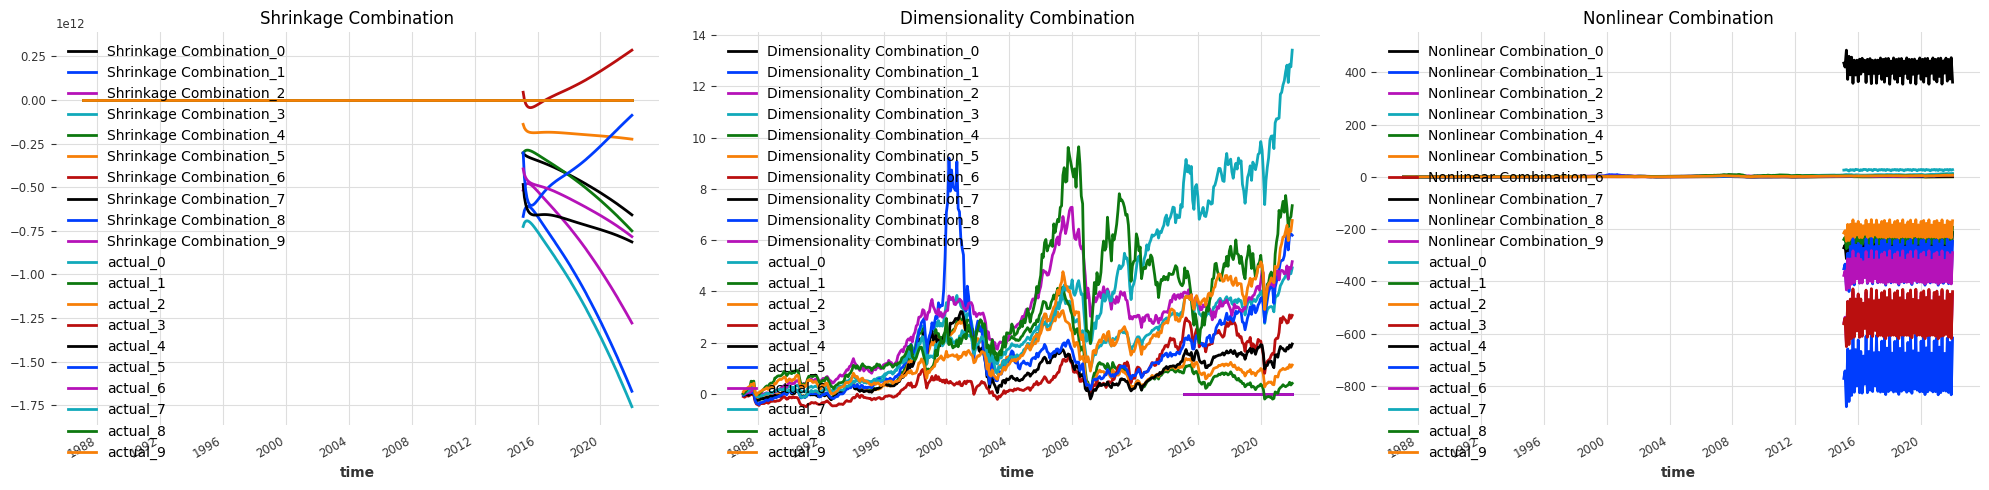

In [55]:
combination_forecasts = {'Shrinkage Combination': shrinkage_ensemble_forecast,
                         'Dimensionality Combination': dim_ensemble_forecast,
                         'Nonlinear Combination': nonlinear_ensemble_forecast}

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()

for i, (name, forecast) in enumerate(combination_forecasts.items()):
    forecast.plot(label=name, ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)
    
plt.tight_layout();

Bei dem Plots ist offentsichtlich ein Fehler, welche ich noch nicht identifizieren konnte. Allerdings habe ich mir die jeweiligen Plots einzeln angeschaut, wo deutliche Ergebnisse abgezeigt werden. Somit liegt der Fehler lediglich im Plot-Statement. 

_____________

Nachdem sowohl die Mittelwerte der jeweiligen Portfolios im Vergleich zum Mittelwert der kumulativen Returns des Ursprungportfolios eher schlecht abgeschnitten haben, ist im folgenden Schritt das Hyperparameter Tuning logisch.

Hyperparameter Tuning ist ein Prozess (bzw. ein Optimierungsproblem), bei dem die Leistung eines maschinellen Lernmodells verbessert wird, indem verschiedene Kombinationen von Hyperparametern ausprobiert werden, um die besten Einstellungen für das Modell zu finden.

Darts bietet hierfür die .gridsearch() Funktion an. Jedes Prognosemodell in Darts bietet eine gridsearch()-Methode für die grundlegende Hyperparametersuche. Diese Methode ist auf sehr einfache Fälle mit sehr wenigen Hyperparametern beschränkt und arbeitet nur mit einer einzigen Zeitreihe.
Somit bietet sich in unserem Fall nicht die Nutzung der .gridearch() Funktion an, da wir mit mehreren Zeitreihen arbeiten.

Überlegen wir uns nochmal welche Paramter überhaupt in der Funktion für zunächst die lineare Regression stecken und planen basierend auf diesen Informationen und den Angeboten in Darts eine Optimierungsmethode für Hyperparameter:

- lags=None: gibt an, wie viele vergangene Zeitpunkte in die Vorhersage eines bestimmten Zeitpunkts einbezogen werden sollen
- lags_past_covariates=None: Eine Liste von Verzögerungen für vergangene Kovariablen, die als Eingabe für das Modell verwendet werden sollen. Kovariablen sind zusätzliche Variablen, die zur Vorhersage der Zielvariable beitragen können.
- lags_future_covariates=None: Eine Liste von Verzögerungen für zukünftige Kovariablen, die als Eingabe für das Modell verwendet werden sollen.
- output_chunk_length=1: gibt an, wie viele zukünftige Zeitpunkte in einem einzigen Vorhersageschritt vorhergesagt werden sollen
- add_encoders=None: Encoders sind Funktionen, die Kovariablen in eine numerische Darstellung umwandeln, die als Eingabe für das Modell verwendet werden kann
- likelihood=None: Standardwerte sind None, was bedeutet, dass die Normalverteilung als Standard-Likelihood-Funktion verwendet wird.
- quantiles=None: Eine Liste von Quantilen, die zur Berechnung von Quantilsregressionen verwendet werden sollen
- random_state=None: Seed, der für die Initialisierung der Modellparameter verwendet werden soll.
- multi_models=True: Boolean, der angibt, ob das Modell für jede Spalte in der Eingabe eine separate lineare Regression durchführen soll
- use_static_covariates=True: Boolean, der angibt, ob statische Kovariablen in das Modell einbezogen werden sollen. Statische Kovariablen sind Kovariablen, die für jeden Zeitpunkt in der Zeitreihe gleich bleiben.

Folgende Parameter sind mEn für die ersten Schritte von Relevanz: lags, output_chunk_length = 1. Wichtig ist somit vorerst nur, wie viele vergangene Monatswerte in die Vorhersage einbezogen werden. Eine Vorhersage von einem Zukunftszeitpunkt ist vorerst ausreichend.